In [208]:
import sys 
#sys.path.append("codes/modules") # add custom Vibe 's modules
#sys.path.append("../..") # add standard 's modules
# sys.path.append('/home/hbkoziel/pyfesom/codes/modules')
sys.path.append('../..') # add standard 's modules
sys.path.append('../modules')

import pyfesom as pf
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
# import mpl_toolkits.axisartist as AA
# from mpl_toolkits.axes_grid1 import host_subplot
import matplotlib.dates as mdates
import numpy as np
from netCDF4 import Dataset
import os
import time
import pandas as pd
import xarray as xr
import datetime

sys.path.append('/home/hbkoziel/pyfesom/pyfesom/cmocean/')
import cmocean as cmap
# sys.path.append('/home/hbkoziel/pyfesom/pyfesom/python-gsw/')
# import gsw

In [209]:
# Loading mesh for run

mesh_id    = 'meshArc4.5'
runid	= 'Arc12'
meshpath   = '/scratch/usr/hbkoziel/mesh/'+mesh_id+'/'            # Defining path where mesh is stored
mesh = pf.load_mesh(meshpath, usepickle=True, get3d=False)        # Loading mesh, stores it in mesh.****  
#mesh = pf.fesom_mesh(meshpath, get3d=True)
#mesh.zlevs = -mesh.zlevs                                            # Depth is made negative
input_directory  = '/scratch/usr/hbkvsk12/hlrn3_work2/results/Arc12/'
derive_variables = 0

/scratch/usr/hbkoziel/mesh/meshArc4.5/pickle_mesh
2
The usepickle == True)
The pickle file for python 2 exists.
The mesh will be loaded from /scratch/usr/hbkoziel/mesh/meshArc4.5/pickle_mesh


In [210]:
ncfile      = meshpath+'Arc4.5.initial.mesh.diag.nc'
f           = Dataset(ncfile, 'r')
NodalAreaModel = f.variables['cluster_area'][:]

In [211]:
if derive_variables == 1:
    ind_all = np.load('index_all.npy')
    doy = np.arange(2,352,2)
    np.shape(doy)
    
    from derivative import derivative
    bafux_2d, bafuy_2d = derivative(mesh)
    f0 = 2*7.2921e-5 * np.sin(mesh.y2/180.*np.pi)
    
    # date in PANDA
    #dates = pd.to_datetime(doy-1, unit='D', origin=str(2014))
    # date in MATPLOTLIB
    dates = [datetime.datetime(2014, 1, 1) + datetime.timedelta(doy[i] - 1)
         for i in range(len(doy))]
    #dates
    
    ind1 = (np.array(mesh.topo > 300))
    ind2 = (np.array(mesh.y2 > 75) & np.array(np.abs(mesh.y2) < 85))
    ind3 = (np.array(mesh.x2 > 100) & np.array(np.abs(mesh.x2) < 140))
    ind_bio=ind1&ind2&ind3
    ind_eastEB = np.squeeze(np.where(ind_bio))
    
    ind = np.max(np.argwhere(mesh.zlevs == 0))
    ind_depth = np.array(mesh.n32[:,ind]) # depth max 580m

    print 'deriving seasonna cycles...'


    ncfile	= input_directory+'/'+runid+'.2014.bio.mean.nc'
    f	= Dataset(ncfile,'r')

    PAR	= f.variables['PAR3D_mean'][:,ind_depth]
    PAR = np.sum(PAR[:,ind_eastEB]*NodalAreaModel[ind_eastEB],axis=1)/np.sum(NodalAreaModel[ind_eastEB])

    print 'deriving PAR done'

    NPP	= f.variables['diags_bio1_mean'][:,:]+f.variables['diags_bio2_mean'][:,:]
    NPP = np.sum(NPP[:,ind_eastEB]*NodalAreaModel[ind_eastEB],axis=1)/np.sum(NodalAreaModel[ind_eastEB])
    NPP = NPP * 12.01 / 1000 # gC / m2

    print 'deriving NPP done'

    ncfile	= input_directory+'/'+runid+'.2014.oce.mean.nc'
    f	= Dataset(ncfile,'r')

    DIN	= f.variables['tr01'][:,ind_depth]
    DIN = np.sum(DIN[:,ind_eastEB]*NodalAreaModel[ind_eastEB],axis=1)/np.sum(NodalAreaModel[ind_eastEB])


    print 'deriving DIN done'

    ncfile	= input_directory+'/'+runid+'.2014.oce.diag.nc'
    f	= Dataset(ncfile,'r')

    MLD	= f.variables['mixlay'][:,:]
    MLD = np.sum(MLD[:,ind_eastEB]*NodalAreaModel[ind_eastEB],axis=1)/np.sum(NodalAreaModel[ind_eastEB])

    print 'deriving MLD done'

    ncfile	= input_directory+'/'+runid+'.2014.ice.mean.nc'
    f	= Dataset(ncfile,'r')

    ICE	= f.variables['area'][:,:]
    ICE = np.sum(ICE[:,ind_eastEB]*NodalAreaModel[ind_eastEB],axis=1)/np.sum(NodalAreaModel[ind_eastEB])


    print 'deriving ICE done'

    ncfile	= input_directory+'/'+runid+'.2014.forcing.diag.nc'
    f	= Dataset(ncfile,'r')

    QNET	= f.variables['qnet'][:,:]
    QNET = np.sum(QNET[:,ind_eastEB]*NodalAreaModel[ind_eastEB],axis=1)/np.sum(NodalAreaModel[ind_eastEB])

    print 'deriving QNET done'
    
    print 'deriving Ekman pumping...'

    ncfile	= input_directory+'/'+runid+'.2014.forcing.diag.nc'
    f	= Dataset(ncfile,'r')

    Wx	= f.variables['stress_x'][:,:]
    Wy  = f.variables['stress_y'][:,:]
    print np.shape(Wx)

    WINDS = np.empty(len(doy))
    for i in range(0,len(doy)):
        (Wx_rot,Wy_rot)   = pf.vec_rotate_r2g(50, 15, -90, mesh.x2, mesh.y2, Wx[i,:], Wy[i,:], flag=1)
        rv_elem = np.sum(Wy_rot[mesh.elem] * bafux_2d,axis=1)+np.sum(Wx_rot[mesh.elem] * bafuy_2d, axis=1) #over triangle
        print i
        #print 'rotation done...'

        RV = np.zeros(len(mesh.x2))*np.nan
        rv_node = np.zeros(len(mesh.x2))
        ind_cnt = np.zeros(len(mesh.x2))
        #print 'looping over elements'
        for ii in range(0,len(mesh.elem)):
            nod_elem=mesh.elem[ii,:]
            rv_node[nod_elem]=rv_node[nod_elem]+rv_elem[ii]
            ind_cnt[nod_elem]=ind_cnt[nod_elem]+1.
        RV = rv_node/ind_cnt
        # print np.shape(RV)
        WINDS[i] = np.sum(RV[ind_eastEB]*NodalAreaModel[ind_eastEB],axis=0)/np.sum(NodalAreaModel[ind_eastEB])


    print 'deriving WIND done'
    
    print 'deriving Ekman pumping...'

    ncfile	= input_directory+'/'+runid+'.2014.forcing.diag.nc'
    f	= Dataset(ncfile,'r')

    Wx	= f.variables['stress_x'][:,:]
    Wy  = f.variables['stress_y'][:,:]
    print np.shape(Wx)

    WINDS = np.empty(len(doy))
    for i in range(0,len(doy)):
        (Wx_rot,Wy_rot)   = pf.vec_rotate_r2g(50, 15, -90, mesh.x2, mesh.y2, Wx[i,:], Wy[i,:], flag=1)
        rv_elem = np.sum(Wy_rot[mesh.elem] * bafux_2d,axis=1)+np.sum(Wx_rot[mesh.elem] * bafuy_2d, axis=1) #over triangle
        print i
        #print 'rotation done...'

        RV = np.zeros(len(mesh.x2))*np.nan
        rv_node = np.zeros(len(mesh.x2))
        ind_cnt = np.zeros(len(mesh.x2))
        #print 'looping over elements'
        for ii in range(0,len(mesh.elem)):
            nod_elem=mesh.elem[ii,:]
            rv_node[nod_elem]=rv_node[nod_elem]+rv_elem[ii]
            ind_cnt[nod_elem]=ind_cnt[nod_elem]+1.
        RV = rv_node/ind_cnt
        # print np.shape(RV)
        WINDS[i] = np.sum(RV[ind_eastEB]*NodalAreaModel[ind_eastEB],axis=0)/np.sum(NodalAreaModel[ind_eastEB])


    print 'deriving WIND done'
    
    print 'deriving Zoo Biomass...'

    ncfile	= input_directory+'/'+runid+'.2014.oce.mean.nc'
    f	= Dataset(ncfile,'r')

    depth = mesh.zlevs
    ind_max_depth = 11
    depth = depth[0:ind_max_depth]

    ZooB2D = np.empty((len(doy),len(depth)))
    ZooB	= f.variables['tr10'][:,:]

    for i in range(0,len(depth)):
        #print depth[i]
        ind_depth = mesh.n32[ind_eastEB,i]-1
        ZooB2D[:,i] = np.sum(ZooB[:,ind_depth]*NodalAreaModel[ind_eastEB],axis=1)/np.sum(NodalAreaModel[ind_eastEB])
        ZooB2D[:,i] = ZooB2D[:,i] * 10 * 12.01 / 1000 # mmol -> gC + depth integration (x10m = layer thickness)

    ZooB1D = np.nansum(ZooB2D, axis = 1);
    print 'done'

    print 'deriving Phy Biomass...'

    ncfile	= input_directory+'/'+runid+'.2014.oce.mean.nc'
    f	= Dataset(ncfile,'r')

    depth = mesh.zlevs
    ind_max_depth = 11
    depth = depth[0:ind_max_depth]

    PhyB2D = np.empty((len(doy),len(depth)))
    PhyB	= f.variables['tr07'][:,:] + f.variables['tr16'][:,:]

    for i in range(0,len(depth)):
        #print depth[i]
        ind_depth = mesh.n32[ind_eastEB,i]-1
        PhyB2D[:,i] = np.sum(PhyB[:,ind_depth]*NodalAreaModel[ind_eastEB],axis=1)/np.sum(NodalAreaModel[ind_eastEB])
        PhyB2D[:,i] = PhyB2D[:,i] * 10 * 12.01 / 1000 # mmol -> gC

    PhyB1D = np.nansum(PhyB2D, axis = 1);
    print 'done'
    
    np.savez('seasonal_laptev.npz', WINDS, dates, doy, ZooB1D.data, PhyB1D.data, PAR.data, NPP.data, ICE.data, MLD.data, QNET.data, DIN.data)
    
elif derive_variables == 0:
    np.load('seasonal_laptev.npz')

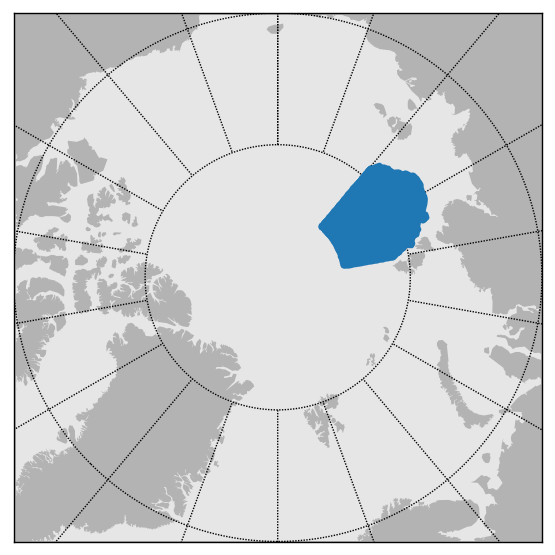

In [212]:
fig = plt.figure(figsize=(15, 15), facecolor='w', edgecolor='k')
#fig.subplots_adjust(wspace=0.02,hspace=0.02)


ax1      = fig.add_subplot(121)
map = Basemap(projection='nplaea',boundinglat=70,lon_0=0,resolution='l')
x, y = map(mesh.x2, mesh.y2)
plabels=[False,False,False,False]
mlabels=[False,False,False,False]    
map.drawparallels(np.arange(-80.,81.,10.), labels=plabels)
map.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
map.drawmapboundary(fill_color='0.9')
map.fillcontinents(color='.7',lake_color='.7')

plt.plot(x[ind_eastEB],y[ind_eastEB],'.')

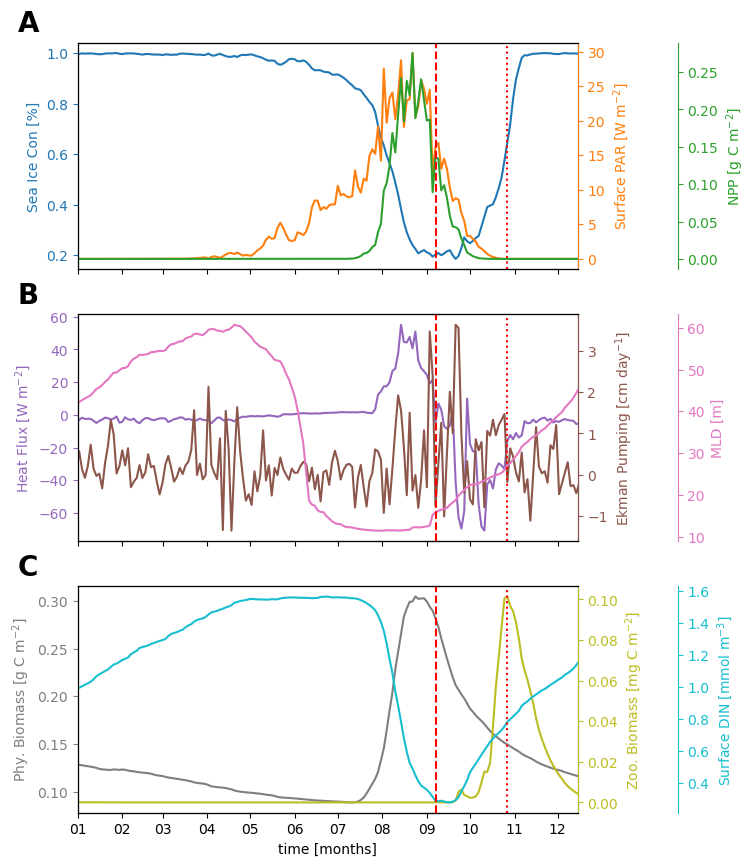

In [215]:
figsize = (8, 10)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=figsize, constrained_layout=True, sharex=True)
fig.subplots_adjust(right=0.75)

#plt.style.use('seaborn-whitegrid')
plt.style.use('default')

# AX1
ax1.plot(dates,ICE,color='C0')
ax1.set_ylabel('Sea Ice Con [%]', color='C0')
ax1.spines['left'].set_color('C0')
ax1.tick_params(axis='y', color='C0', labelcolor='C0')
ax1.set_xlim([datetime.date(2014, 1, 1), datetime.date(2014, 12, 15)])

ax1b = ax1.twinx()
ax1b.spines['right'].set_color('C1')
ax1b.tick_params(axis='y', color='C1', labelcolor='C1')
ax1b.plot(dates,PAR, color='C1')
ax1b.set_ylabel('Surface PAR [W m$^{-2}$]', color='C1')

ax1c = ax1.twinx()
ax1c.spines["right"].set_position(("axes", 1.2))
ax1c.spines['right'].set_color('C2')
ax1c.tick_params(axis='y', color='C2', labelcolor='C2')
ax1c.set_ylabel('NPP [g C m$^{-2}$]', color='C2')
ax1c.plot(dates,NPP,color='C2')

# Major ticks every 12 months.
fmt_half_year = mdates.MonthLocator(interval=12)
ax1c.xaxis.set_major_locator(fmt_half_year)
# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax1c.xaxis.set_minor_locator(fmt_month)
# Text in the x axis will be displayed in 'YYYY-mm' format.
ax1c.xaxis.set_major_formatter(mdates.DateFormatter('%m'))

#AX2
ax2.plot(dates,QNET,color='C4')
ax2.set_ylabel('Heat Flux [W m$^{-2}$]', color='C4')
ax2.spines['left'].set_color('C4')
ax2.tick_params(axis='y', color='C4', labelcolor='C4')

ax2b = ax2.twinx()
ax2b.spines['right'].set_color('C5')
ax2b.tick_params(axis='y', color='C5', labelcolor='C5')
ax2b.plot(dates,WINDS*100*24*3600, color='C5')
ax2b.set_ylabel('Ekman Pumping [cm day$^{-1}$]', color='C5')

ax2c = ax2.twinx()
ax2c.spines["right"].set_position(("axes", 1.2))
ax2c.spines['right'].set_color('C6')
ax2c.tick_params(axis='y', color='C6', labelcolor='C6')
ax2c.set_ylabel('MLD [m]', color='C6')
ax2c.plot(dates,MLD,color='C6')

#AX3
ax3.plot(dates,PhyB1D,color='C7')
ax3.set_ylabel('Phy. Biomass [g C m$^{-2}$]', color='C7')
ax3.spines['left'].set_color('C7')
ax3.tick_params(axis='y', color='C7', labelcolor='C7')
ax3.set_xlabel('time [months]')

ax3b = ax3.twinx()
ax3b.spines['right'].set_color('C8')
ax3b.tick_params(axis='y', color='C8', labelcolor='C8')
ax3b.plot(dates,ZooB1D*1000, color='C8')
ax3b.set_ylabel('Zoo. Biomass [mg C m$^{-2}$]', color='C8')

ax3c = ax3.twinx()
ax3c.spines["right"].set_position(("axes", 1.2))
ax3c.spines['right'].set_color('C9')
ax3c.tick_params(axis='y', color='C9', labelcolor='C9')
ax3c.set_ylabel('Surface DIN [mmol m$^{-3}$]', color='C9')
ax3c.plot(dates,DIN,color='C9')

# Major ticks every 12 months.
fmt_half_year = mdates.MonthLocator(interval=1)
ax3c.xaxis.set_major_locator(fmt_half_year)
# Minor ticks every month.
fmt_month = mdates.MonthLocator()
ax3c.xaxis.set_minor_locator(fmt_month)
# Text in the x axis will be displayed in 'YYYY-mm' format.
ax3c.xaxis.set_major_formatter(mdates.DateFormatter('%m'))

ax1c.axvline(dates[248/2], color='r', linestyle='--')
ax2c.axvline(dates[248/2], color='r', linestyle='--')
ax3c.axvline(dates[248/2], color='r', linestyle='--')

ax1c.axvline(dates[298/2], color='r', linestyle=':')
ax2c.axvline(dates[298/2], color='r', linestyle=':')
ax3c.axvline(dates[298/2], color='r', linestyle=':')
#fig.autofmt_xdate()

ax1.text(-0.12, 1.05, 'A', transform=ax1.transAxes,
            size=20, weight='bold')
ax2.text(-0.12, 1.05, 'B', transform=ax2.transAxes,
            size=20, weight='bold')
ax3.text(-0.12, 1.05, 'C', transform=ax3.transAxes,
            size=20, weight='bold')

plt.savefig('seasonnal_Laptev.png', dpi = 300, bbox_inches='tight') 

In [214]:
print "Annual integrated values /m2 :"
print "NPP /m2 = ",np.trapz(NPP,doy)
print "Phy C Biomass /m2 = ",np.trapz(PhyB1D,doy)
print "Zoo C Biomass /m2 = ",np.trapz(ZooB1D,doy)

Annual integrated values /m2 :
NPP /m2 =  8.475051594551394
Phy C Biomass /m2 =  48.34879257699474
Zoo C Biomass /m2 =  0.0029663951653899775
